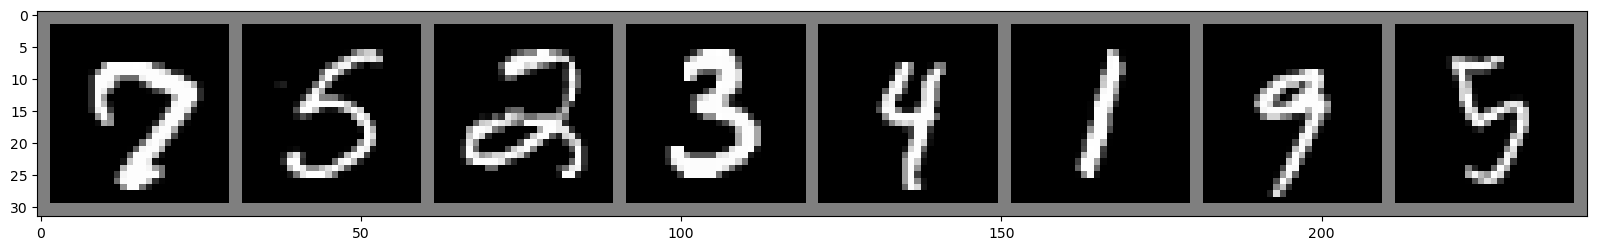

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5788205..2.3407059].


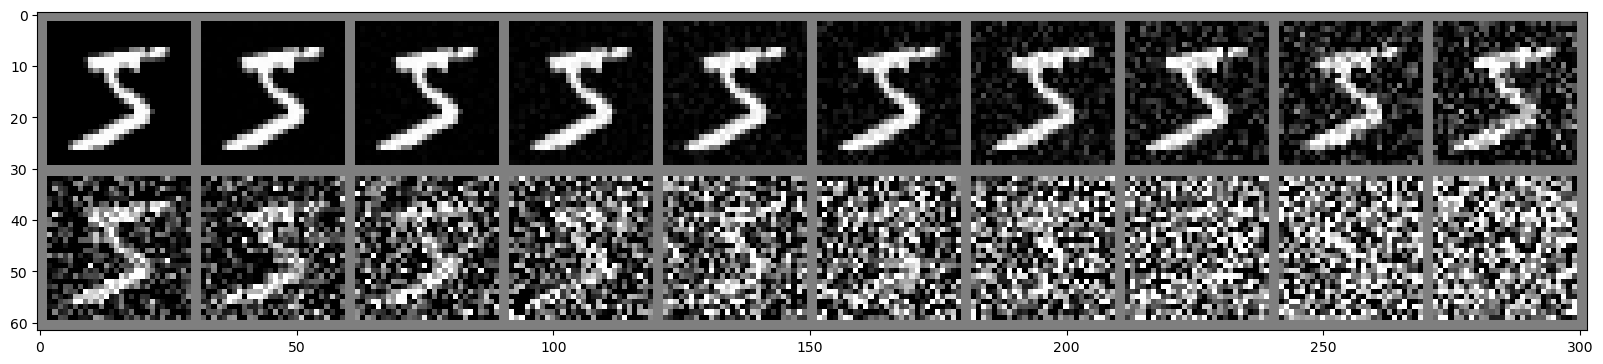

In [6]:
import utils
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

image_size = 28
classes_by_index  = np.arange(0,10).astype('str')

transform = transforms.Compose([transforms.Resize(image_size),\
                                transforms.ToTensor(),\
                                transforms.Normalize([0.5],[0.5])]) #Normalize to -1,1
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:8]
labels = labels[:8]

# show images
imshow(torchvision.utils.make_grid(images))
sde = utils.VPSDE(T_max=1, beta_min=0.01, beta_max=10.0)
n_time_slides = 20
time_vec = torch.linspace(0,1,n_time_slides)**2
X_0 = torch.stack([trainset[0][0].squeeze()] * n_time_slides)
X_t, noise, score = sde.run_forward(X_0, torch.linspace(0, 1.0, n_time_slides)**2)
imshow(torchvision.utils.make_grid(X_t.unsqueeze(1), nrow=10))

In [7]:
N_TIMESTEPS = 100
n_channels = 1
TRAIN_SCORE = False 

model = utils.Unet(base_dim=image_size, in_channels=n_channels, out_channels=n_channels, time_embedding_dim=256, timesteps=N_TIMESTEPS, dim_mults=[2, 4], temp=100.0)
# model = torch.compile(model)
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-2 #2e-5
WEIGHT_DECAY = 0.0
N_EPOCHS = 100
RETRAIN = False
def train(model, sde: utils.ItoSDE, dataloader: DataLoader, 
              optimizer, device, scheduler: None, 
              n_epochs: int, train_score: bool=False):
    model = model.to(device)
    model.train()
    loss_function = nn.MSELoss(reduction='mean')
    loss_list = []
    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        for idx, data in enumerate(dataloader):
            X_0 = data[0]
            optimizer.zero_grad()
            X_t, noise, score, time = sde.run_forward_random_time(X_0)
            X_t = X_t.to(device); noise = noise.to(device); time = time.to(device); score = score.to(device)
            score_pred = model(X_t, time)
            if train_score:
                loss = loss_function(score, score_pred)
            else:
                loss = loss_function(noise, score_pred)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.detach().item())
            print(loss.detach().item())
            if scheduler:
                scheduler.step()
    return model, loss_list

if RETRAIN:
    optimizer = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,LEARNING_RATE,total_steps=N_EPOCHS*len(trainloader),pct_start=0.25,anneal_strategy='cos')
    model, running_loss_list = train(model, sde, trainloader, train_score=TRAIN_SCORE, optimizer=optimizer, device=device, n_epochs=N_EPOCHS, scheduler=scheduler)
    torch.save(model.state_dict(),"./models/Sampling_diffusion_denoiser.ckpt")
else:
    model_state_dict = torch.load("./models/Sampling_diffusion_denoiser.ckpt")
    model.load_state_dict(model_state_dict)

C:\Users\14153\AppData\Local\Temp\ipykernel_4076\1781558923.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("./models/Sampling_diffusion_d

In [13]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = utils.run_backwards(model, sde, X_0=x_start, n_steps=1000, device=device, train_score=TRAIN_SCORE, plot_evolution=False)
output = output.transpose(1, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3047676..4.820235].


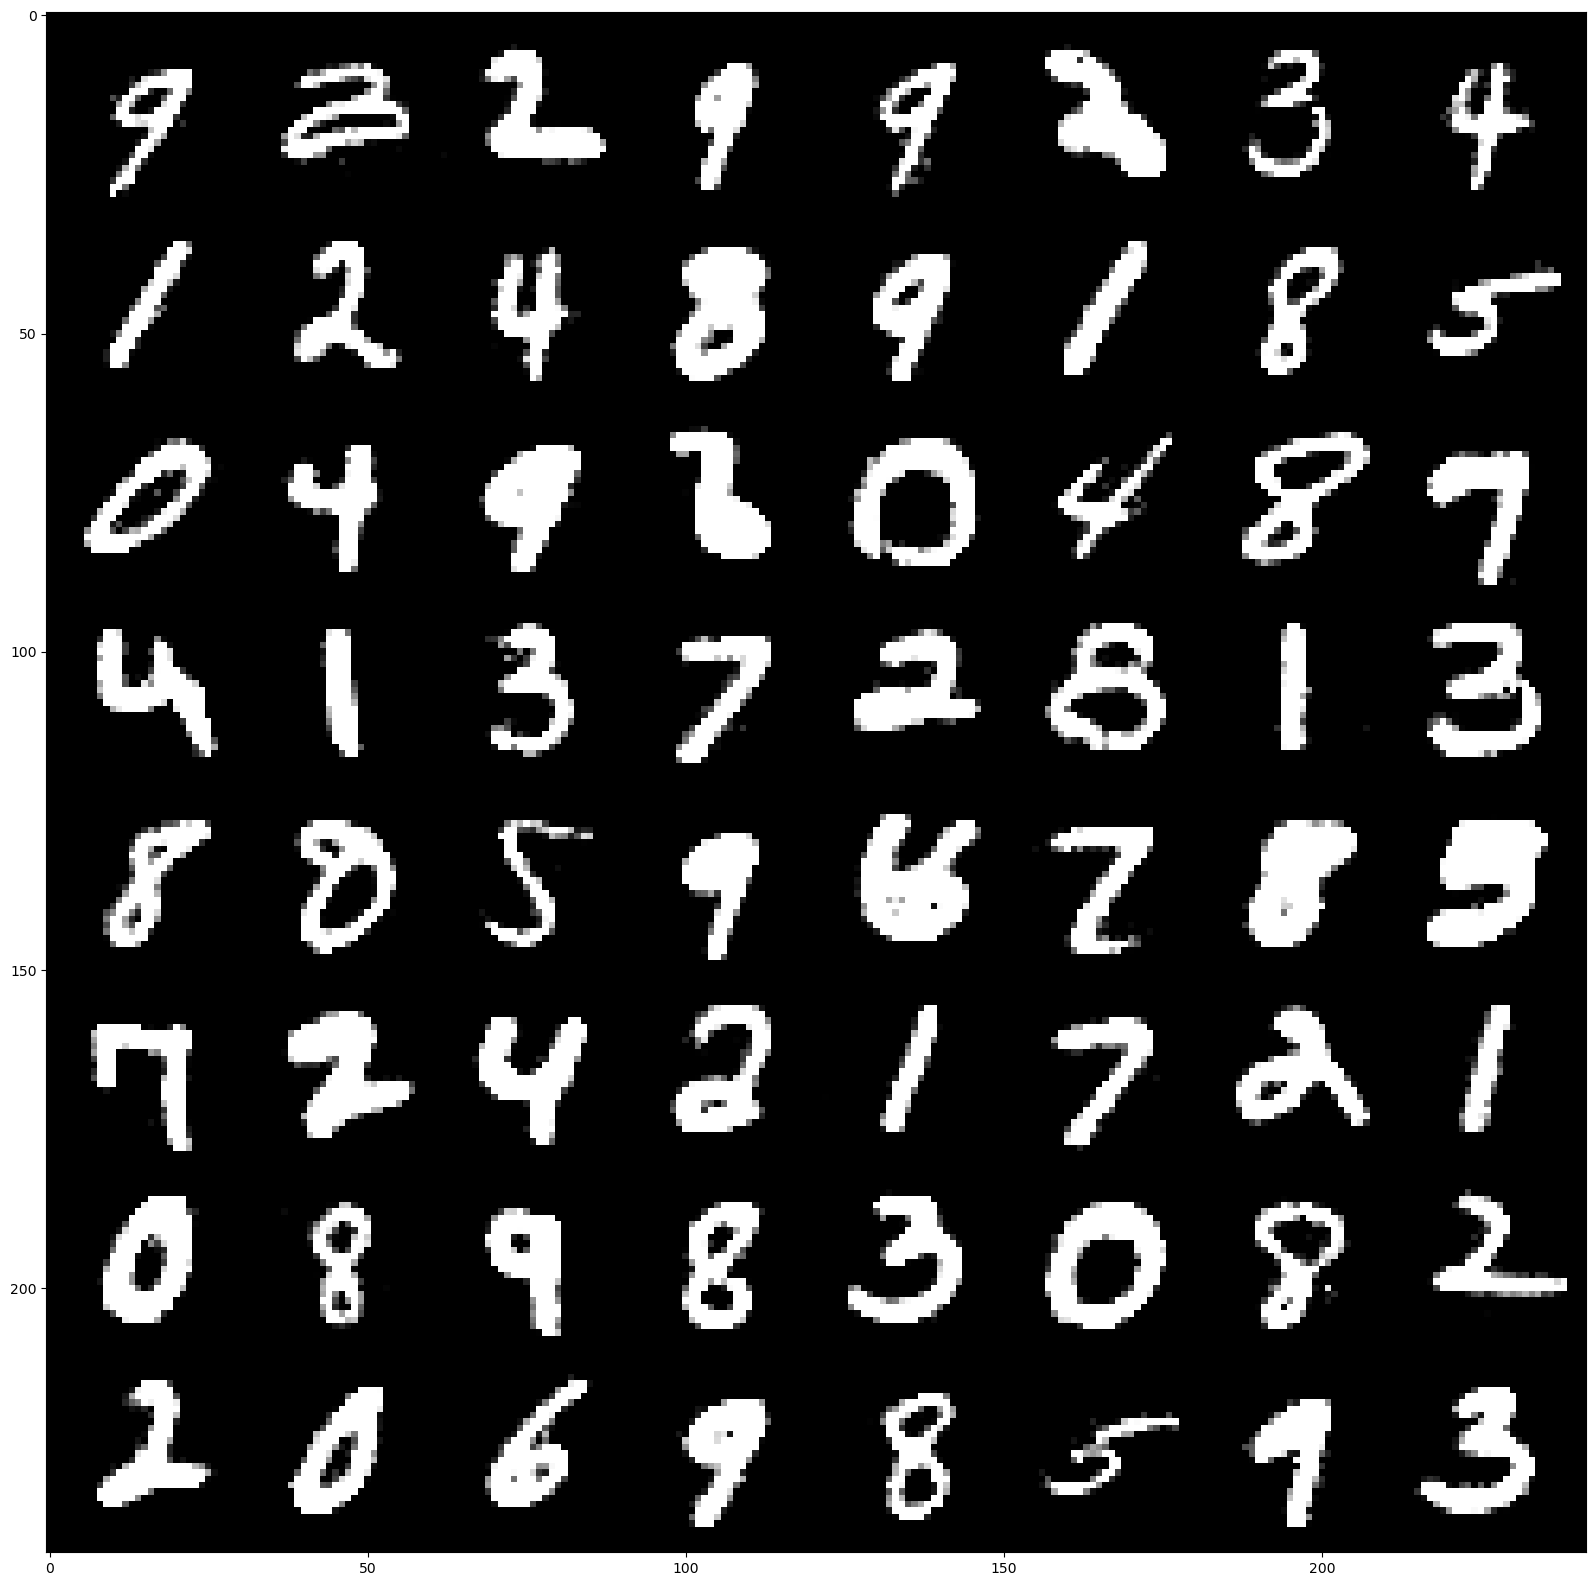

In [14]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(output[:, -1]))

In [16]:
print(output.shape)
def make_gif():
    n_images = 20
    time_jumps = output.shape[1]//n_images
    idx_list = [i * time_jumps for i in range(n_images)] + [output.shape[1]-1]
    image_paths = []
    for idx in idx_list:
        imshow(torchvision.utils.make_grid(output[:, idx]))
        filepath = f"mnist_gen_idx={idx}.png"
        plt.savefig(filepath)
        image_paths.append(filepath)
    
    frames = [Image.open(image) for image in image_paths+[image_paths[-1]]*min(len(image_paths),15)]
    frame_one = frames[0]
    frame_one.save("./pics/denoising_MNIST_diffusion.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    for image_path in image_paths:
       os.remove(image_path)
# make_gif()

torch.Size([64, 1001, 1, 28, 28])
